# Modeling JC Stages With SAOT

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from saot import *

# SA-OT On All Landscapes

Apply each hierarchy to the typology and evaluate the candidates -> obtain 6 landscapes on which to perform SA-OT hill climbing to search for optima. Perform the seach many times and compute the outcome proportions in each hierarchy. 

In [ ]:
# ----- Running SA-OT for multiple hierarchies -----
def sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=K_VALUES_DEFAULT, n=1000, verbose=False):
    """Run SA-OT for multiple hierarchies and return results."""
    if verbose:
        print(f"Running SA-OT for {len(hierarchies)} hierarchies with {n} runs each...")
    
    results = {h: [] for h in hierarchies.keys()}
    
    for h_name, h in hierarchies.items():
        grammar = {c: k_values[i] for i, c in enumerate(h)}
        if verbose:
            print(f"Running SA-OT for {h_name}: {' >> '.join(c.__name__ + f' (K={K})' for c, K in grammar.items())}")
        for _ in range(n):
            final_sf = sa_ot(initial_sf, grammar=grammar, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50, seed=None)
            results[h_name].append(final_sf)
    
    return results

n=100
results = sa_ot_multiple_runs(n=n, verbose=True)

Running SA-OT for 6 hierarchies with 100 runs each...
Running SA-OT for H1: faith_neg (K=4) >> star_neg (K=3) >> neg_first (K=2) >> neg_last (K=1)
Running SA-OT for H2: faith_neg (K=4) >> neg_first (K=3) >> star_neg (K=2) >> neg_last (K=1)
Running SA-OT for H3: faith_neg (K=4) >> neg_first (K=3) >> neg_last (K=2) >> star_neg (K=1)
Running SA-OT for H4: faith_neg (K=4) >> neg_last (K=3) >> neg_first (K=2) >> star_neg (K=1)
Running SA-OT for H5: faith_neg (K=4) >> neg_last (K=3) >> star_neg (K=2) >> neg_first (K=1)
Running SA-OT for H6: faith_neg (K=4) >> star_neg (K=3) >> neg_last (K=2) >> neg_first (K=1)


,H1,H2,H3,H4,H5,H6
[SN V],100.0,60.0,0.0,0.0,0.0,0.0
[SN [V SN]],0.0,40.0,48.0,62.0,0.0,0.0
[[SN V] SN],0.0,0.0,52.0,38.0,49.0,0.0
[V SN],0.0,0.0,0.0,0.0,51.0,100.0


,H1,H2,H3,H4,H5,H6
[SN V],1.0,0.6,0.00,0.00,0.00,0.0
[SN [V SN]],0.0,0.4,0.48,0.62,0.00,0.0
[[SN V] SN],0.0,0.0,0.52,0.38,0.49,0.0
[V SN],0.0,0.0,0.00,0.00,0.51,1.0


<Figure size 1200x600 with 0 Axes>

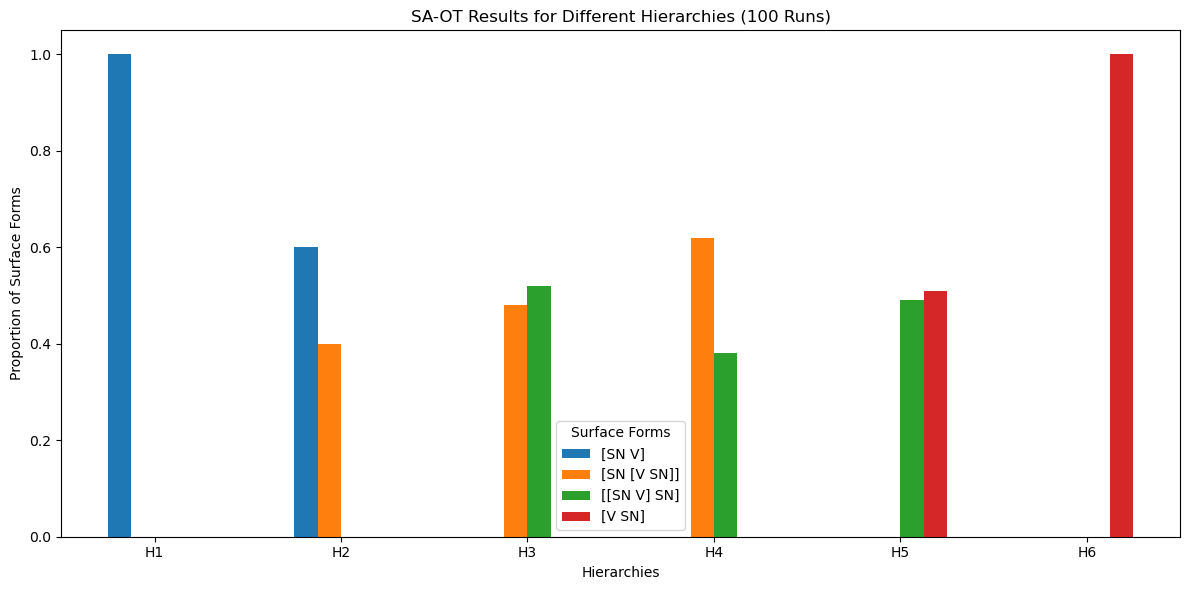

In [ ]:
# ----- Analyzing results -----
def analyze_results(results, pretty=True, flat=False):
    """Analyze results from SA-OT runs: counts and proportions of surface forms.
    
    Args:        
        results (dict): Dictionary with hierarchy names as keys and lists of surface forms as values.
        pretty (bool): If True, serialize surface forms to strings for better readability.
        flat (bool): If True, flatten the surface forms to a list of strings.   
        
    Returns:
        tuple: DataFrames with counts and proportions of surface forms per hierarchy.
    """    
    if pretty:
        # Flatten the sf's in the production history to a list of surface forms
        results = {h_name: [serialize_sf(sf, flat=flat) for sf in sfs]
                    for h_name, sfs in results.items()}
    elif flat:
        # Flatten the sf structures
        results = {h_name: [flatten_sf(sf) for sf in sfs]
                    for h_name, sfs in results.items()}
    else:
        # Keep the original nested structure of surface forms, converting them to strings for hashing
        results = {h_name: [str(sf) for sf in sfs]
                    for h_name, sfs in results.items()}
    
    # Convert production history dict to DataFrame
    results_df = pd.DataFrame(results)  # rows: runs, columns: hierarchies, cells: surface forms
    sf_order = sorted(set(results_df.values.ravel()), key=lambda sf: sf.replace('[', '').replace(']', ''))  # Sort surface forms to match expected order given hierarchies
    
    # Count the occurrences of each surface form per generation 
    counts = results_df.apply(lambda x: x.value_counts()).fillna(0)
    # Reorder rows (i.e., surface forms) in counts according to sf_order
    counts = counts.loc[sf_order]

    # Convert counts to proportions
    proportions = counts.apply(lambda x: x / x.sum(), axis=0) 
    
    return counts, proportions


# ----- Visualizing results -----
counts_df, proportions_df = analyze_results(results, pretty=True, flat=False)
display(counts_df)
display(proportions_df)

# Plotting the results
plt.figure(figsize=(12, 6))
proportions_df.T.plot(kind='bar', figsize=(12, 6))
plt.title(f'SA-OT Results for Different Hierarchies ({n} Runs)')
plt.xlabel('Hierarchies')
plt.ylabel('Proportion of Surface Forms')
plt.xticks(rotation=0)
plt.legend(title='Surface Forms')
plt.tight_layout()
plt.show()

# Different K-values

Hierarchies 2 and 5 introduce both a global optimum (preverbal negation [SN V] and postverbal negation [V SN], respectively) and a local optimum (the forms of discontinuous negation [SN [V SN]] and [[SN V] SN], repsectively). Simulated annealing applied to these hierarchies produces the global optimum (the "grammatical form") with frequency `p`, and the other local optimum (the "performance errors") with frequency `1 − p`. Thus, `p` is the precision of SA-OT: the probability of finding the grammatical form. The value of this probability depends on the parameters of the algorithm. While `K_max` and `t_step` seem to have minimal impact according to Lopopolo and Biro, the athours find that reducing the ranking value of the lowest-ranked constraint makes the value of `p` vary from a bit over 0.5 to almost 1.0. This is what we test below. Note that from the point of view of traditional OT, decreasing the rank of the lowest ranked constraint does not change the grammar since the order of the constraints remains the same, and the harmony of the candidates are also unaffected. 

In [ ]:
k_values_last = [i for i in range(1, -11, -1)]

all_results = {}

for k in k_values_last:
    n = 100  # Number of runs for each hierarchy
    print(f"Running {n} SA-OT simulations for k={k}...")
    k_values = np.array([4, 3, 2, k])
    results = sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=k_values, n=n, verbose=False)

    # Count surface forms and compute proportions
    _, results_proportions = analyze_results(results, pretty=True, flat=True)

    # Convert proportions to DataFrame
    all_results[k] = pd.DataFrame(results_proportions).fillna(0) 

Running 100 SA-OT simulations for k=1...
Running 100 SA-OT simulations for k=0...
Running 100 SA-OT simulations for k=-1...
Running 100 SA-OT simulations for k=-2...
Running 100 SA-OT simulations for k=-3...
Running 100 SA-OT simulations for k=-4...
Running 100 SA-OT simulations for k=-5...
Running 100 SA-OT simulations for k=-6...
Running 100 SA-OT simulations for k=-7...
Running 100 SA-OT simulations for k=-8...
Running 100 SA-OT simulations for k=-9...
Running 100 SA-OT simulations for k=-10...


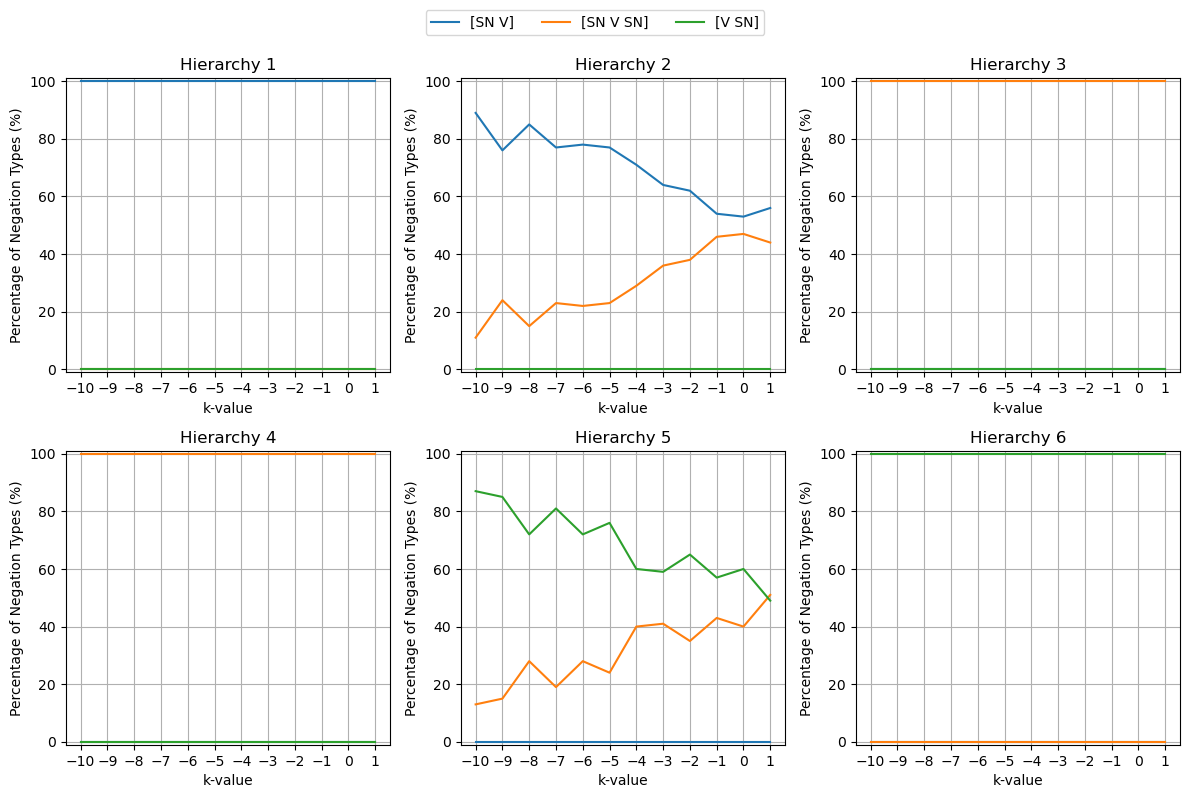

In [ ]:
# ----- Plotting the results for each hierarchy across k-values -----

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Go through each hierarchy and plot surface form proportions across k-values
for ax, (h_name, _) in zip(axes.flat, HIERARCHIES_DICT.items()):
    # Build a DataFrame: rows are k-values, columns are prettified surface forms
    df = pd.DataFrame({
        k: all_results[k][h_name] if h_name in all_results[k] else pd.Series()
        for k in k_values_last
    }).T.fillna(0)

    for sf in df.columns:
        ax.plot(k_values_last, df[sf] * 100, label=sf)

    ax.set_title(f'Hierarchy {h_name[-1]}')  # \n{">>".join(c.__name__ for c in HIERARCHIES_DICT[h_name])}
    ax.set_xlabel('k-value')
    ax.set_ylabel('Percentage of Negation Types (%)')
    ax.set_xticks(k_values_last)
    ax.set_ylim(-1, 101)
    ax.grid(True)

# Create legend from last processed df (assuming all dfs share same surface forms)
fig.legend(labels=df.columns, loc='upper center', ncol=len(df.columns), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
